# Original PanAns Comparison

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
from gsw import SA_from_SP, p_from_z

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/v45/akm157/figures/IAF_meltwater/'

In [3]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44185/status,
Dashboard: /proxy/44185/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42587,Workers: 0
Dashboard: /proxy/44185/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:41599,Total threads: 1
Dashboard: /proxy/37327/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:44323,


#### Testing for corrupted file

In [34]:
path_test_M = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output022/20020101.ocean_month.nc')
path_test_C =  xr.open_mfdataset(np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/2002*.ocean_month.nc')), chunks='auto')
area_test = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello']

In [35]:
area_sum = area_test.sum(dim={'xh','yh'}).load()

In [36]:
test_runoff_M = path_test_M['lrunoff']
test_runoff_C = path_test_C['lrunoff']
test_runoff_anom = test_runoff_M - test_runoff_C

In [44]:
test_runoff_time_C = (test_runoff_C*area_test).sum('xh').sum('yh')/area_sum
test_runoff_time_M = (test_runoff_M*area_test).sum('xh').sum('yh')/area_sum
test_runoff_time = (test_runoff_anom*area_test).sum('xh').sum('yh')/area_sum

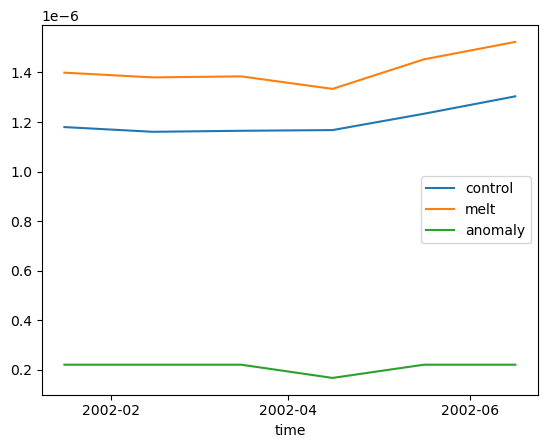

In [48]:
test_runoff_time_C.sel(time=slice('2002-01-02','2002-07-01')).plot(label='control')
test_runoff_time_M.plot(label='melt')
test_runoff_time.plot(label='anomaly')
plt.xlim
plt.legend()

so output022 file from the perturbation is the issue. 

In [53]:
test_space_M = test_runoff_M.sel(time='2002-05') #problem month
test_space_C = test_runoff_C.sel(time='2002-05')
test_space_M

<xarray.DataArray 'lrunoff' (time: 1, yh: 845, xh: 3600)> Size: 12MB
[3042000 values with dtype=float32]
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14
  * time     (time) object 8B 2002-05-16 12:00:00
Attributes:
    units:          kg m-2 s-1
    long_name:      Liquid runoff (rivers) into ocean
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  water_flux_into_sea_water_from_rivers

(-270.0, -210.0)

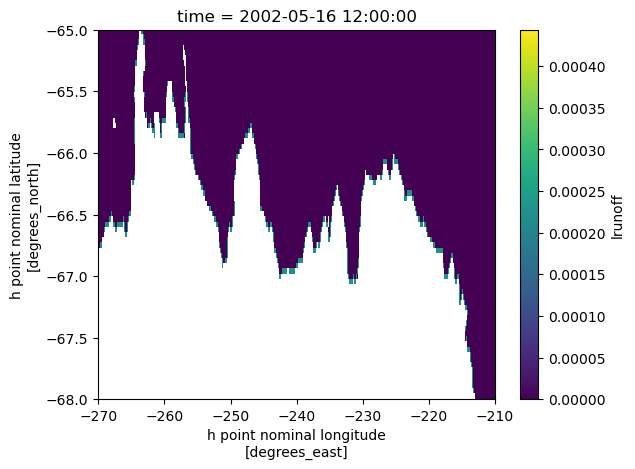

In [54]:
test_space_anom = test_space_M - test_space_C
test_space_anom.plot()
plt.ylim(-68,-65)
plt.xlim(-270,-210)

In [58]:
# Get only the non-zero values
grid = test_space_M.drop_vars('time')
# If grid is xarray, get the underlying NumPy array
arr = grid.values if hasattr(grid, "values") else grid

# Flatten to 1D
non_zero_values = arr[arr != 0].ravel()

# Check if all non-zero values are equal
all_same = np.all(non_zero_values == non_zero_values[0]) if non_zero_values.size > 0 else True

print("All non-zero cells have the same value:", all_same)

All non-zero cells have the same value: False


## Plotting the PanAns

In [66]:
save_dir = '/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/'

runoff_pert_01 = xr.open_dataarray(save_dir + 'runoff_pert_pan01.nc')
runoff_minus_restoring_change_01 = xr.open_dataarray(save_dir + 'runoff_minus_restoring_change_pan01.nc')
restoring_change_01 = xr.open_dataarray(save_dir + 'restoring_change_pan01.nc')

runoff_pert_005 = xr.open_dataarray(save_dir + 'runoff_pert_pan005.nc')
runoff_minus_restoring_change_005 = xr.open_dataarray(save_dir + 'runoff_minus_restoring_change_pan005.nc')
restoring_change_005 = xr.open_dataarray(save_dir + 'restoring_change_pan005.nc')

In [67]:
runoff_pert_01 = runoff_pert_01.to_series()
runoff_minus_restoring_change_01 = runoff_minus_restoring_change_01.to_series()
restoring_change_01 = restoring_change_01.to_series()
runoff_pert_005 = runoff_pert_005.to_series()
runoff_minus_restoring_change_005 = runoff_minus_restoring_change_005.to_series()
restoring_change_005 = restoring_change_005.to_series()

Text(0.5, 1.0, 'Runoff and restoring integrated over shelf')

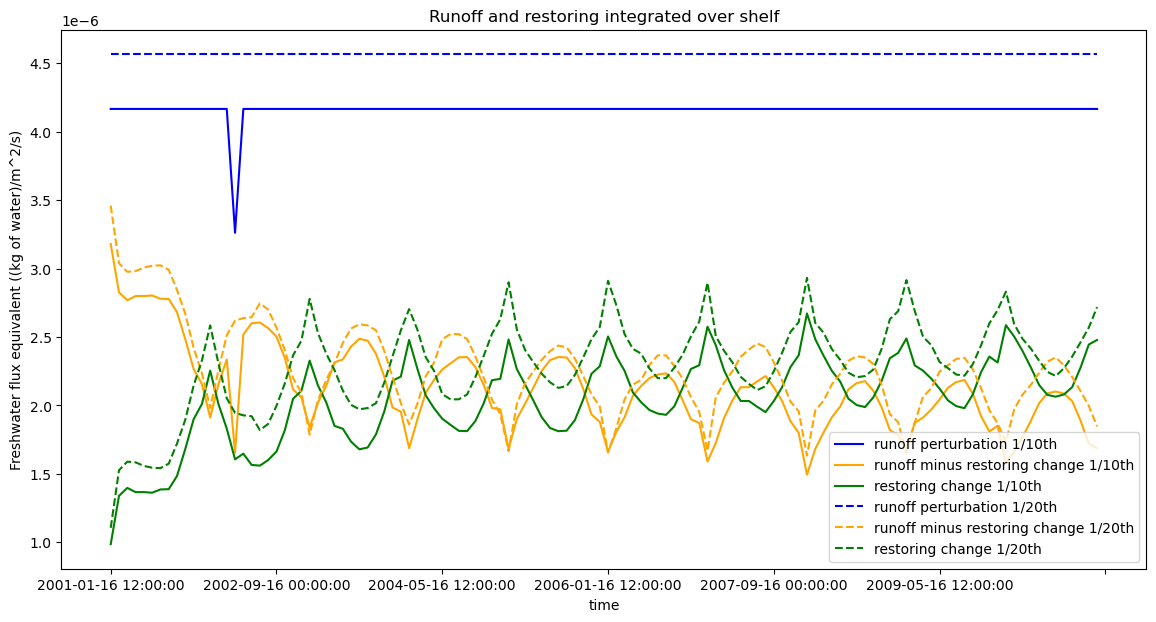

In [76]:
# units of both should be (kg of water)/m^2/s averaged over the shelf:

plt.figure(figsize=(14,7))

runoff_pert_01.plot(label='runoff perturbation 1/10th', color='b')
runoff_minus_restoring_change_01.plot(label='runoff minus restoring change 1/10th',color='orange')
restoring_change_01.plot(label='restoring change 1/10th',color='g')

runoff_pert_005.plot(label='runoff perturbation 1/20th',color='b',linestyle='--')
runoff_minus_restoring_change_005.plot(label='runoff minus restoring change 1/20th',color='orange',linestyle='--')
restoring_change_005.plot(label='restoring change 1/20th',color='g',linestyle='--')

plt.legend(loc='lower right')
plt.ylabel('Freshwater flux equivalent ((kg of water)/m^2/s)')
plt.title('Runoff and restoring integrated over shelf')
#plt.ylim(0,2.1e-6)